# NLP lab #1
### Дмитрий Тронин, Игорь Рухович, 22МАГИАД

##### Data: **Large Movie Review Dataset** (https://ai.stanford.edu/~amaas/data/sentiment/)

# Imports

In [179]:
import re
import time
from collections import Counter, OrderedDict
from itertools import chain, islice
from statistics import mean

import gensim.downloader as api
import nltk
import nltk.corpus
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import xgboost as xgb
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.sparse import csc_matrix, dok_array, lil_matrix
from scipy.sparse.linalg import svds
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.nn.functional import pad
from torch.utils.data import DataLoader
from torchtext.vocab import vocab
from tqdm.notebook import tqdm

sns.set_theme()
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/wsl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wsl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data_path_local = "../data/imdb_dataset.csv"
data_path_kaggle = "/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
is_local = True

data_path = data_path_local if is_local else data_path_kaggle

dataset = pd.read_csv(data_path)

## EDA

Рассмотрим датасет ревью на фильмы с разметкой настроения

In [6]:
dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Рассмотрим самые популярные слова: 

In [13]:
word_counter = Counter(chain.from_iterable((sentence.split(' ') for sentence in dataset['review'])))
word_counter.most_common(20)

[('the', 568723),
 ('a', 306953),
 ('and', 301892),
 ('of', 283618),
 ('to', 261847),
 ('is', 203047),
 ('in', 169976),
 ('I', 132488),
 ('that', 126811),
 ('this', 113720),
 ('it', 107894),
 ('/><br', 100974),
 ('was', 92656),
 ('as', 83127),
 ('with', 82563),
 ('for', 80914),
 ('The', 67290),
 ('but', 66261),
 ('on', 61192),
 ('movie', 60754)]

Видим, что чаще всего встречаются предлоги, артикли, местоимения. Возможно, их стоит удалить. Также встретилось сочетание `/><br`, значит необходимо также отчистить текст от HTML тегов.

Найдем среднюю длину отзыва (в словах):

In [14]:
review_lenghts = dataset['review'].apply(lambda x: len(x.split(' ')))
review_lenghts.mean()

231.14594

Гистограмма распределения длин отзывов:

<Axes: xlabel='review', ylabel='Count'>

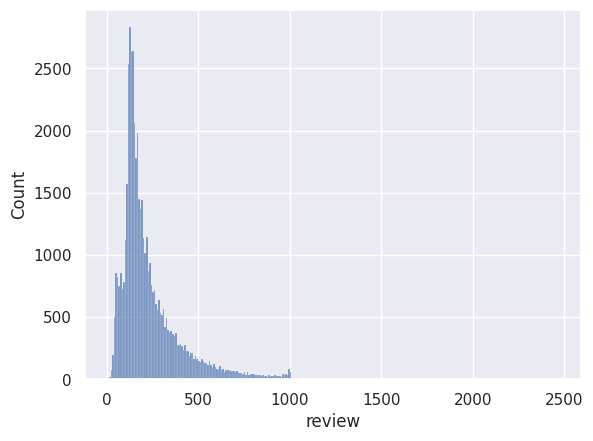

In [15]:
sns.histplot(data=review_lenghts)

In [18]:
review_lenghts.describe()

count    50000.000000
mean       231.145940
std        171.326419
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review, dtype: float64

По гистограмме и квантилям видим, что бОльшая часть отзывов содержит >100 слов. Это означает, что нам должно хватить информации для определения тона отзыва (мало коротких отзывов).

Средняя длина слова:

In [29]:
word_lenghts = dataset['review'].apply(lambda x: mean([len(word) for word in x.split(" ")]))
word_lenghts.mean()

4.640919633485693

Найдем среднее количество предложений в отзыве:

In [19]:
sentence_counts = dataset['review'].apply(lambda x: len(x.split('. ')))
sentence_counts.mean()

9.82322

В среднем отызывы достаточно длинные, что также говорит в пользу предыдущего утверждения.

Среднее количество слов в предложении:

In [20]:
sentence_word_count = []
for _, review in dataset['review'].items():
    for sentence in review.split('. '):
        if sentence:
            sentence_word_count.append(len(sentence.split(' ')))
                                       
mean(sentence_word_count)

23.56663458244286

Рассмотрим баланс классов:

In [21]:
dataset['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Классы сбалансированы.

## Preprocessing

Функция предобработки текста:

1. приведение к нижнему регистру
2. удаление HTML тегов и пунктуации
3. фильтрация стоп-слов

In [33]:
def preprocess_text(text, stopwords, lemmatizer):
    lowered_text = text.lower().strip()
    filtered_text = re.sub(r'<[^>]*>|[^a-zA-Z]', ' ', lowered_text) # clean from punctuation and HTML tags
    lemmed_text = ' '.join(lemmatizer.lemmatize(text) for text in filtered_text.split() if text not in stopwords)
    return lemmed_text

[nltk_data] Downloading package stopwords to /home/wsl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Применим функцию выше к датасету:

In [34]:
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

dataset['preprocessed_review'] = dataset['review'].apply(lambda text: preprocess_text(text, stopwords, lemmatizer))

Пример обработки текста было/стало

In [41]:
dataset.iloc[0].values

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

## Word Vectorizer

Токенизируем тексты:

In [44]:
documents = [word_tokenize(text) for text in dataset['preprocessed_review']]
vocabulary = set(chain.from_iterable(documents))
token_to_index = {token: i for i, token in enumerate(vocabulary)}
index_to_token = {i: token for token, i in token_to_index.items()}

In [171]:
def plot_with_matplotlib(x_vals, y_vals, labels_w_index, plot_all=True):
    plt.figure(figsize=(12, 12))
    if not plot_all:
        idx = [v for k,v in labels_w_index]
        x_vals = x_vals[idx]
        y_vals = y_vals[idx]
        labels_w_index = [(k[0], i) for i, k in enumerate(labels_w_index)]

    plt.scatter(x_vals, y_vals, s=10)

    for label, idx in labels_w_index:
        # Randomly move annotation on +-3
        mv = np.random.rand(2) * 6 - 3
        plt.annotate(label, (x_vals[idx] + mv[0], y_vals[idx] + mv[1]))

### Матрица совстречаемости

Подготовим маппинги для всех контекстов в датасете:

In [55]:
WINDOW_SIZE = 7
contexts = set()
for document in tqdm(documents, total=len(documents)):
    for i in range(len(document) - WINDOW_SIZE + 1):
        current_combination = document[i: i + WINDOW_SIZE]
        current_context = tuple(sorted(current_combination[:WINDOW_SIZE // 2] + current_combination[WINDOW_SIZE // 2 + 1:]))
        contexts.add(current_context)
context_to_index = {token: i for i, token in enumerate(contexts)}
index_to_context = {i: token for token, i in context_to_index.items()}

  0%|          | 0/50000 [00:00<?, ?it/s]

Подготовим матрицу совстречаемости:

In [56]:
coocurence_context_matrix = dok_array((len(vocabulary), len(contexts)))

for document in tqdm(documents, total=len(documents)):
    for i in range(len(document) - WINDOW_SIZE + 1):
        current_combination = document[i: i + WINDOW_SIZE]
        current_context = tuple(sorted(current_combination[:WINDOW_SIZE // 2] + current_combination[WINDOW_SIZE // 2 + 1:]))
        coocurence_context_matrix[token_to_index[current_combination[WINDOW_SIZE // 2]], context_to_index[current_context]] += 1           
            

  0%|          | 0/50000 [00:00<?, ?it/s]

Получим эмбеддинги с помощью частичного SVD разложения:

In [57]:
coocurence_words_emb, _, coocurence_contexts_emb = svds(coocurence_context_matrix, k=10)

Уменьшим размерность с помощью TSNE для визуализации:

In [58]:
coocurence_words_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(coocurence_words_emb)

##### **На всех графиках здесь и далее аннотации будут случайно равномерно смещены до 3 единиц в любую сторону для удобства чтения**

Text(0.5, 1.0, 'Двумерное отображение эмбеддингов и некоторых слов')

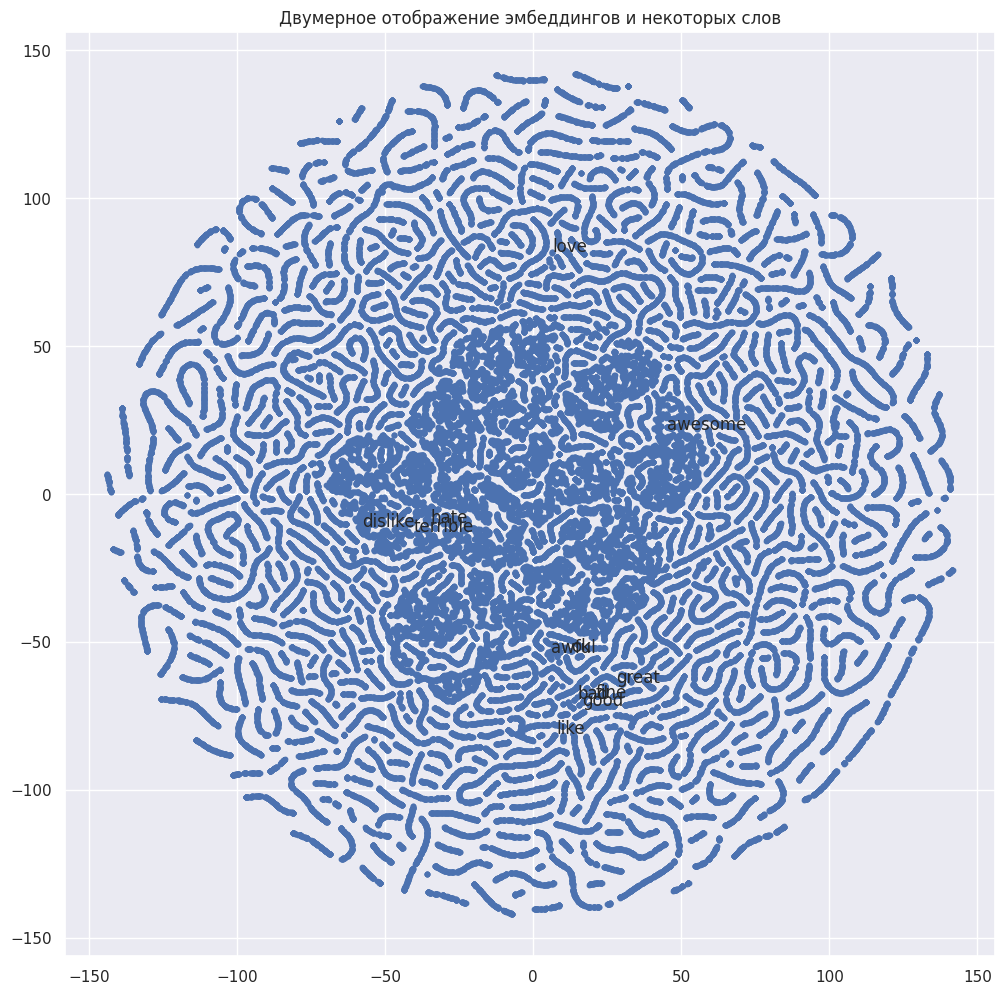

In [172]:
lookup_words = ['like', 'dislike', 'hate',
                'love', 'fine', 'awful',
                'ok', 'great', 'bad',
                'good', 'awesome', 'terrible']

plot_with_matplotlib(coocurence_words_emb_tsne[:, 0],
                     coocurence_words_emb_tsne[:, 1],
                     [(word, token_to_index[word]) for word in lookup_words])
plt.title('Двумерное отображение эмбеддингов и некоторых слов')

Text(0.5, 1.0, 'Двумерное отображение эмбеддингов и некоторых слов')

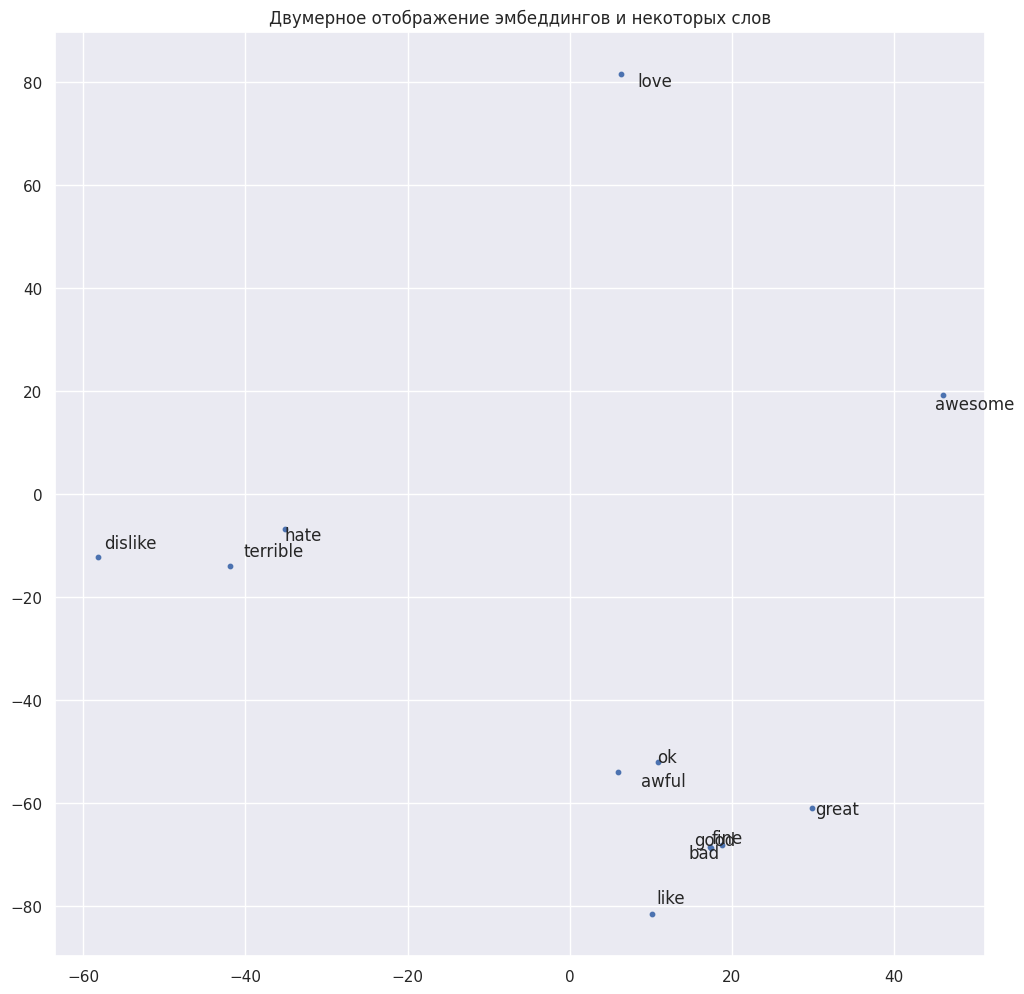

In [173]:
plot_with_matplotlib(coocurence_words_emb_tsne[:, 0],
                     coocurence_words_emb_tsne[:, 1],
                     [(word, token_to_index[word]) for word in lookup_words],
                     False)
plt.title('Двумерное отображение эмбеддингов и некоторых слов')

Некоторые ключевые слова получилось разделить, но не все (судя по результатам TSNE). Например, "good", "fine" и "bad" оказались, практически, в одной точке. Это может быть связано с тем, что антонимы могут употребляться в похожих контекстах.

### PPMI

Подготовим необходимые статистики и матрицу совстречаемости:

In [60]:
ppmi_matrix = dok_array((len(vocabulary), len(contexts)))

word_counts = np.zeros(len(vocabulary))
context_counts = np.zeros(len(contexts))
coocurence_contex_matrix = dok_array((len(vocabulary), len(contexts)))

for document in tqdm(documents, total=len(documents)):
    for i in range(len(document) - WINDOW_SIZE + 1):
        current_combination = document[i: i + WINDOW_SIZE]
        current_context = tuple(sorted(current_combination[:WINDOW_SIZE // 2] + current_combination[WINDOW_SIZE // 2 + 1:]))
        coocurence_contex_matrix[token_to_index[current_combination[WINDOW_SIZE // 2]], context_to_index[current_context]] += 1
        context_counts[context_to_index[current_context]] += 1
        word_counts[token_to_index[current_combination[WINDOW_SIZE // 2]]] += 1

  0%|          | 0/50000 [00:00<?, ?it/s]

Расчищаем PPMI матрицу:

In [61]:
non_zero_x, non_zero_y = coocurence_contex_matrix.nonzero()
sum_words = word_counts.sum()
sum_contexts = context_counts.sum()
sum_coocurence = coocurence_contex_matrix.sum()

ppmi_matrix = dok_array((len(vocabulary), len(contexts)))

for x, y in tqdm(zip(non_zero_x, non_zero_y), total=len(non_zero_x)):
    current_ppmi = np.log2((coocurence_contex_matrix[x, y] / sum_coocurence) / ((context_counts[y] / sum_contexts) * (word_counts[x] / sum_words)))
    if current_ppmi > 0:
        ppmi_matrix[x, y] = current_ppmi

  0%|          | 0/5559092 [00:00<?, ?it/s]

Получим эмбеддинги с помоью SVD разложения:

In [62]:
ppmi_words_emb, _, ppmi_contexts_emb = svds(ppmi_matrix, k=10)

Уменьшим размерность с помощью TSNE для визуализации:

In [63]:
ppmi_words_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(ppmi_words_emb)

Text(0.5, 1.0, 'Двумерное отображение эмбеддингов и некоторых слов (PPMI)')

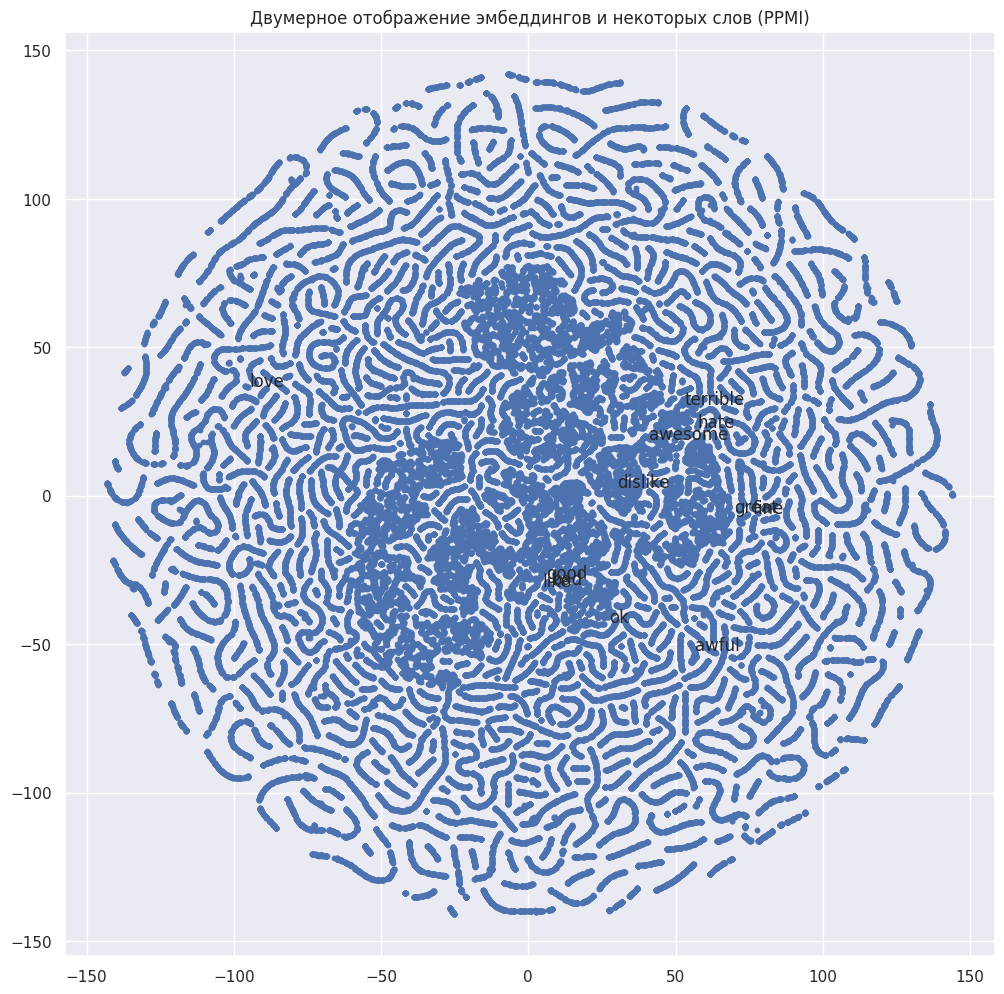

In [174]:
plot_with_matplotlib(ppmi_words_emb_tsne[:, 0],
                     ppmi_words_emb_tsne[:, 1],
                     [(word, token_to_index[word]) for word in lookup_words])
plt.title('Двумерное отображение эмбеддингов и некоторых слов (PPMI)')

Text(0.5, 1.0, 'Двумерное отображение эмбеддингов и некоторых слов (PPMI)')

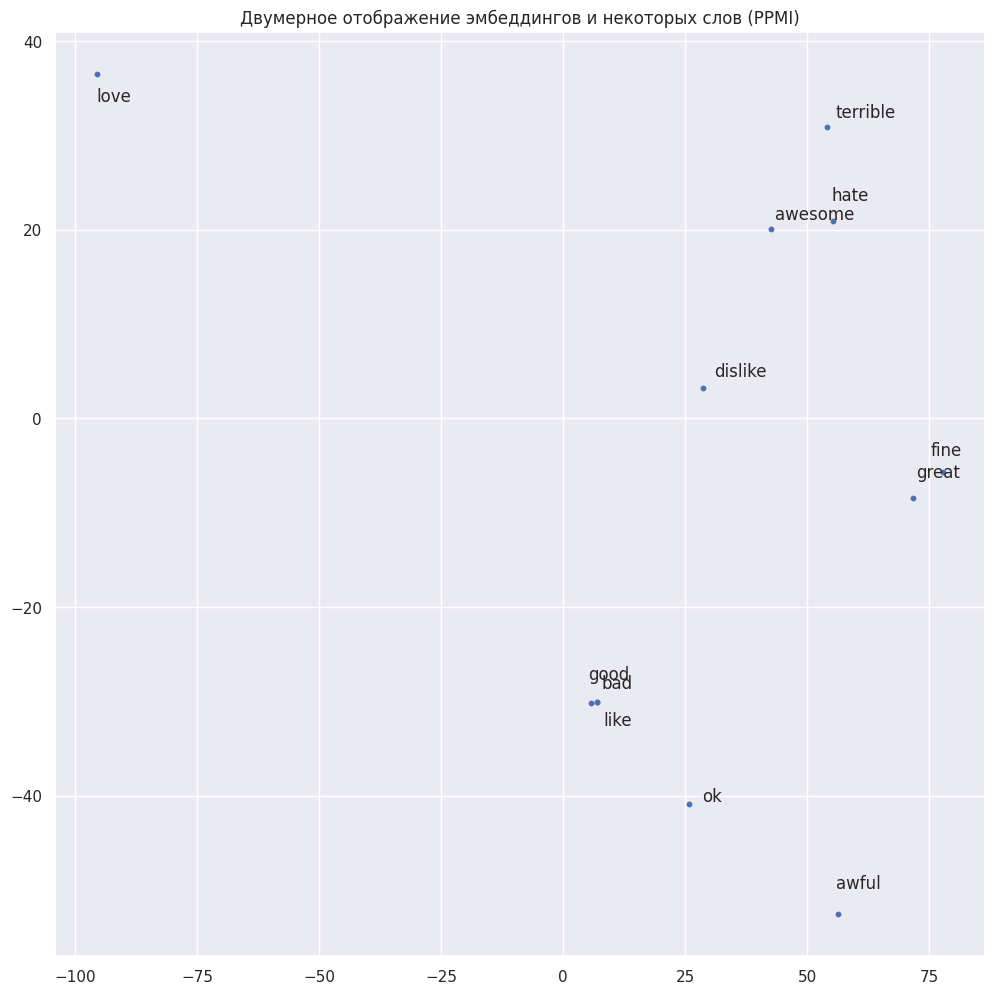

In [175]:
plot_with_matplotlib(ppmi_words_emb_tsne[:, 0],
                     ppmi_words_emb_tsne[:, 1],
                     [(word, token_to_index[word]) for word in lookup_words],
                     False)
plt.title('Двумерное отображение эмбеддингов и некоторых слов (PPMI)')

Так как методы основываются на одном и том то результат похож на предудыщий: какие-то слова разделяются, а какие-то нет. Например, "good", "like" и "bad" по прежнему практически не различимы (согласно TSNE). Другие, похожие слова, наоборот оказались после сжатия слишком далеко.

## W2V

Натренируем w2v на наших отзывах

In [119]:
w2v_model = Word2Vec(vector_size=100, sentences=documents)

In [120]:
w2v_words_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(np.asarray(w2v_model.wv.vectors))

Text(0.5, 1.0, 'Двумерное отображение эмбеддингов и некоторых слов (W2V)')

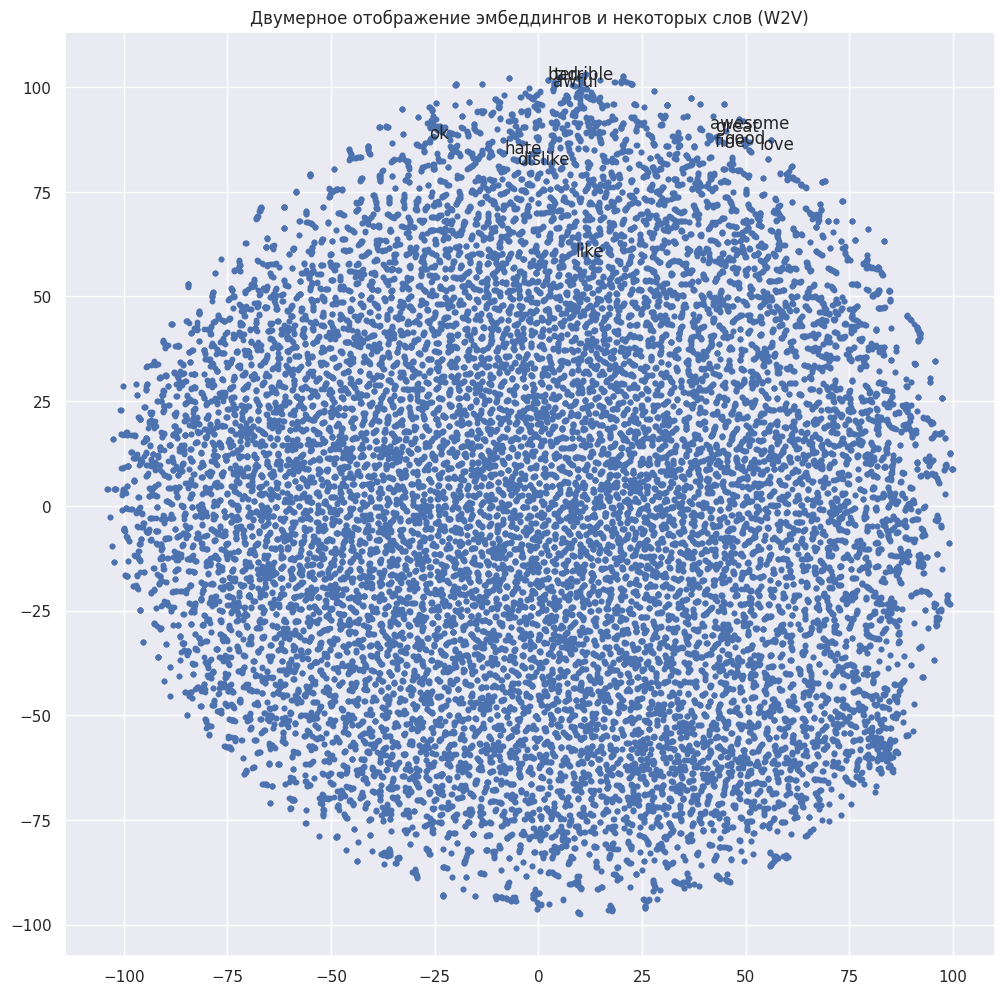

In [176]:
plot_with_matplotlib(w2v_words_emb_tsne[:, 0],
                     w2v_words_emb_tsne[:, 1],
                     [(word, next(i for i, x in enumerate(w2v_model.wv.index_to_key) if x == word)) for word in lookup_words])
plt.title('Двумерное отображение эмбеддингов и некоторых слов (W2V)')

Text(0.5, 1.0, 'Двумерное отображение эмбеддингов и некоторых слов (W2V)')

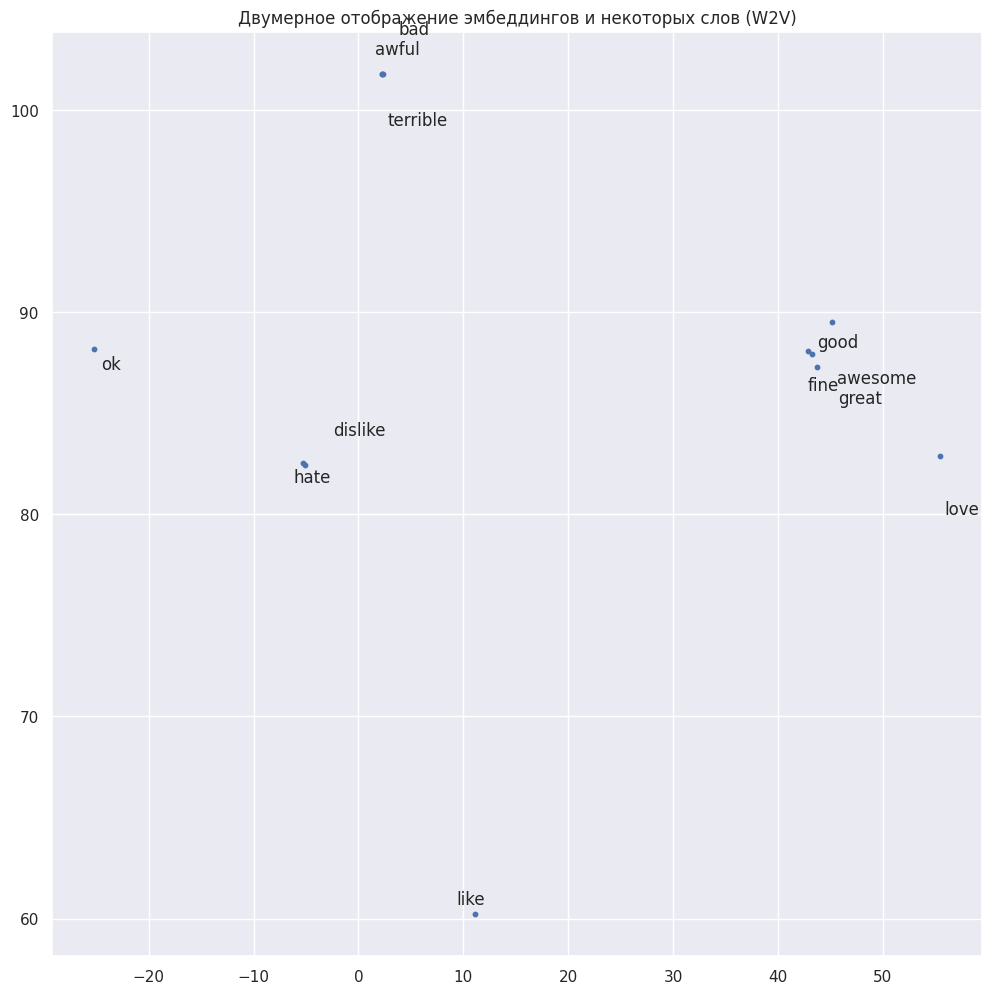

In [177]:
plot_with_matplotlib(w2v_words_emb_tsne[:, 0],
                     w2v_words_emb_tsne[:, 1],
                     [(word, next(i for i, x in enumerate(w2v_model.wv.index_to_key) if x == word)) for word in lookup_words],
                     False)
plt.title('Двумерное отображение эмбеддингов и некоторых слов (W2V)')

Отображение стало намного лучше. В близких кластерах теперь только синонимы. W2V побеждает среди других алгоритмов векторизации в этом сравнении

# Модели

Поделим датасет на обучающую и валидационные выборки (20% на валидацию):

In [231]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, shuffle=True)
train_documents = [word_tokenize(text) for text in train_dataset['preprocessed_review']]
test_documents = [word_tokenize(text) for text in test_dataset['preprocessed_review']]

## Классические модели

Попробуем за эмбеддинг текста взять усреднение эмбеддингов слов из w2v

In [232]:
text_embedings_by_avg_train = []
for document in tqdm(train_documents):
    embedding = np.zeros(w2v_model.wv.vectors.shape[1])
    ops = 0
    for word in document:
        if word in w2v_model.wv.key_to_index:
            embedding += w2v_model.wv.vectors[w2v_model.wv.key_to_index[word]]
            ops += 1
    text_embedings_by_avg_train.append(embedding / ops)
text_embedings_by_avg_train = np.array(text_embedings_by_avg_train)
y_train = train_dataset["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values

text_embedings_by_avg_test = []
for document in tqdm(test_documents):
    embedding = np.zeros(w2v_model.wv.vectors.shape[1])
    ops = 0
    for word in document:
        if word in w2v_model.wv.key_to_index:
            embedding += w2v_model.wv.vectors[w2v_model.wv.key_to_index[word]]
            ops += 1
    text_embedings_by_avg_test.append(embedding / ops)
text_embedings_by_avg_test = np.array(text_embedings_by_avg_test)
y_test = test_dataset["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Logistic Regression

In [240]:
scaler = StandardScaler().fit(text_embedings_by_avg_train)
logreg_clf = LogisticRegression(random_state=0).fit(scaler.transform(text_embedings_by_avg_train), y_train)

In [241]:
print(f"Train accuracy: {accuracy_score(y_train, logreg_clf.predict(scaler.transform(text_embedings_by_avg_train)))}")
print(f"Test accuracy: {accuracy_score(y_test, logreg_clf.predict(scaler.transform(text_embedings_by_avg_test)))}")

Train accuracy: 0.86675
Test accuracy: 0.8663


Видим, что простая логистическая регрессия очень неплохо справляется с поставленной задачей.

Это может говорить о том, что для принятия решения достаточно правильно учесть некоторые частотные характеристики каких-то слов. Поэтому работает подход, где эмбеддинг текста является средним эмбеддингом слов.

## XGBoost

Попробуем более сложный классический алгоритм - градиентный бустинг.

Увеличим максимальную глубину деревьев, но ограничим число листовых нод. Тем самым дадим больше свободы алгоритму, контролируя при этом переобучение. Для принятия решения о разделении листа будем перебирать всех возможных кандидатов.

In [275]:
xgb_clf = xgb.XGBClassifier(tree_method="exact",
                            max_depth=8,
                            grow_policy="lossguide",
                            max_leaves=50)
xgb_clf.fit(text_embedings_by_avg_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=50,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [276]:
print(f"Train accuracy: {accuracy_score(y_train, xgb_clf.predict(text_embedings_by_avg_train))}")
print(f"Test accuracy: {accuracy_score(y_test, xgb_clf.predict(text_embedings_by_avg_test))}")

Train accuracy: 0.999525
Test accuracy: 0.857


От бустинга не получилось добиться более хорошего результата.

Это может говорить о том, что бОльшая часть данных неплохо линейно разделима, но дальнейшее усложнение классических алгоритмов не принесет значимых результатов (остальные эмбеддинги перемешаны).

## Нейросетевые подходы

Подготовим исходные данные: токенизируем преобработанный текст

In [14]:
class_to_label = {"positive": 1, "negative": 0}

train_dataset_tokenized = []
for _, row in tqdm(train_dataset.iterrows(), total=len(train_dataset)):
    train_dataset_tokenized.append((class_to_label[row['sentiment']], word_tokenize(row['preprocessed_review'].lower())))
    
test_dataset_tokenized = []
for _, row in tqdm(test_dataset.iterrows(), total=len(test_dataset)):
    test_dataset_tokenized.append((class_to_label[row['sentiment']], word_tokenize(row['preprocessed_review'].lower())))

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
train_sentences = [text.lower() for _, text in train_dataset['preprocessed_review'].items()]

w2v_model = Word2Vec(vector_size=300)
w2v_model.build_vocab((text for _, text in train_dataset_tokenized))
w2v_model.wv.vectors_lockf = np.ones(len(w2v_model.wv))

pretrained_model_path='/kaggle/working/word2vec-google-news-300.gz'
# pretrained_model_path= '/kaggle/working/glove-wiki-gigaword-100.gz'
# pretrained_model_path = gensim.downloader.load('glove-wiki-gigaword-100', return_path=True)
w2v_model.wv.intersect_word2vec_format(pretrained_model_path, lockf=1.0, binary=True)

In [94]:
# !mv /root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz /kaggle/working/glove-wiki-gigaword-100.gz

mv: cannot stat '/root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz': No such file or directory


Подготовим словарь для эмбеддингов в нейросети:

In [16]:
vocabulary = vocab(OrderedDict((token, 1) for token in w2v_model.wv.key_to_index.keys()), specials=['<UNK>', '<PAD>'], special_first=False)
vocabulary.set_default_index(vocabulary(['<UNK>'])[0])

Подготовим датасеты и функцию предобработки (добавление паддинга и преобразование в нужный формат):

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    labels = []
    text_tensors = []
    max_length = max((len(text) for _, text in batch))
    for label, text in batch:
        labels.append(label)
        text_tensors.append(pad(torch.tensor(text), (0, max_length - len(text)), value=vocabulary(['<PAD>'])[0]))        
        
    labels_tensor = torch.tensor(labels)
    text_tensor = torch.vstack(text_tensors)
    return labels_tensor.to(device), text_tensor.to(device)
    

train_dataset_mapped = [(label, vocabulary(text)) for label, text in train_dataset_tokenized]
test_dataset_mapped = [(label, vocabulary(text)) for label, text in test_dataset_tokenized]

train_dataloader = DataLoader(train_dataset_mapped, batch_size=500, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset_mapped, batch_size=100, shuffle=False, collate_fn=collate_batch)

Вспомогательные функции для обучения:

In [18]:
def train_step(model, criterion, optimizer, dataloader, epoch_idx, train_accuracy):
    model.train()
    total_acc, total_count = 0, 0
    
    loss_t = [0]
    
    for idx, (label, text) in enumerate(dataloader):
        predicted_label = model(text)
        loss =  criterion(predicted_label, label)
        
#         print("Before")
#         for name, data in model.named_parameters():
#             if data.grad is not None and name == 'fc_1.weight':
#                 print("Name", name)
#                 print("Weights", data.data)
#                 print("Grad", data.grad)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         print("After")
#         for name, data in model.named_parameters():
#             if data.grad is not None and name == 'fc_1.weight':
#                 print("Name", name)
#                 print("Grad", data.grad)
#                 print("Grad", data.grad.norm())

        
        
        current_loss = float(loss.detach().cpu().numpy()) / label.shape[0]        
        loss_t.append(current_loss)
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
        if idx % 50 == 0:
            print(f"| Epoch {epoch_idx} | batch {idx} | loss {mean(loss_t)}")
        
    accuracy = total_acc / total_count
    print()
    print(f"| Epoch {epoch_idx} | training accuracy {accuracy} | mean loss {mean(loss_t)}")
    train_accuracy[epoch_idx] = accuracy
    

def evaluate_step(model, criterion, dataloader, epoch_idx, eval_accuracy):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    accuracy = total_acc / total_count
    print(f"| Epoch {epoch_idx} | validation accuracy {accuracy}")
    eval_accuracy[epoch_idx] = accuracy


In [19]:
def train(model, criterion, optimizer, epochs, train_dataloader, test_dataloader):
    train_accuracy = {}
    eval_accuracy = {}
    for epoch_idx in range(epochs):
        train_step(model, criterion, optimizer, train_dataloader, epoch_idx, train_accuracy)
        evaluate_step(model, criterion, test_dataloader, epoch_idx, eval_accuracy)
        print()
    
    return train_accuracy, eval_accuracy
        

### CNN модель

Архитектура:

In [20]:
class CNNModel(nn.Module):
    def __init__(self, embedding_vectors, hidden_size=100, dropout_prob=0.3):
        super(CNNModel, self).__init__()
        
        embedding_size = len(embedding_vectors[0])

        embedding_tensor = torch.vstack([torch.FloatTensor(embedding_vectors), torch.zeros((2, embedding_size))])
        
        self.embeddings = nn.Embedding.from_pretrained(embedding_tensor)
#         self.embeddings = nn.Embedding(len(embedding_vectors) + 2, embedding_size)
        
        self.convolution_1 = nn.Conv1d(embedding_size, hidden_size, 5)
        self.convolution_2 = nn.Conv1d(embedding_size, hidden_size, 15)
        self.convolution_3 = nn.Conv1d(embedding_size, hidden_size, 45)
        
        self.avg_max_pooling = nn.AdaptiveAvgPool1d(1)
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.batch_norm = nn.BatchNorm1d(hidden_size * 3,)
        
        self.fc = nn.Linear(hidden_size * 3, 2)
        
        
    def forward(self, batch):        
        with torch.no_grad():
            embeddings = self.embeddings(batch).transpose(1, 2)     
    
        conv_1 = self.convolution_1(embeddings)
        pooling_1 = self.dropout(self.avg_max_pooling(conv_1).squeeze(-1))
        conv_2 = self.convolution_1(embeddings)
        pooling_2 = self.dropout(self.avg_max_pooling(conv_2).squeeze(-1))
        conv_3 = self.convolution_1(embeddings)
        pooling_3 = self.dropout(self.avg_max_pooling(conv_3).squeeze(-1))
        
        
        hidden_state = self.batch_norm(torch.cat([pooling_1, pooling_2, pooling_3], dim=1))
        
        return nn.functional.softmax(nn.functional.relu(self.fc(hidden_state)), dim=-1)         
        
        

In [21]:
cnn_model = CNNModel(w2v_model.wv.vectors, hidden_size=100, dropout_prob=0.5).to(device)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
cnn_train_results = train(cnn_model, criterion, optimizer, 10, train_dataloader, test_dataloader)

| Epoch 0 | batch 0 | loss 0.0007027208805084229
| Epoch 0 | batch 50 | loss 0.0010462546463196095

| Epoch 0 | training accuracy 0.803925 | mean loss 0.0010064155334307823
| Epoch 0 | validation accuracy 0.8402

| Epoch 1 | batch 0 | loss 0.00045366445183753966
| Epoch 1 | batch 50 | loss 0.0009083018520703683

| Epoch 1 | training accuracy 0.84335 | mean loss 0.000916404585779449
| Epoch 1 | validation accuracy 0.8245

| Epoch 2 | batch 0 | loss 0.0004655260145664215
| Epoch 2 | batch 50 | loss 0.0009066071028892811

| Epoch 2 | training accuracy 0.84505 | mean loss 0.000910892591064359
| Epoch 2 | validation accuracy 0.8461

| Epoch 3 | batch 0 | loss 0.00043399545550346373
| Epoch 3 | batch 50 | loss 0.0008911835184464088

| Epoch 3 | training accuracy 0.850825 | mean loss 0.0009022616052333219
| Epoch 3 | validation accuracy 0.8471

| Epoch 4 | batch 0 | loss 0.00044526302814483645
| Epoch 4 | batch 50 | loss 0.0008925476784889515

| Epoch 4 | training accuracy 0.852375 | mean los

Text(0.5, 1.0, 'CNN модель')

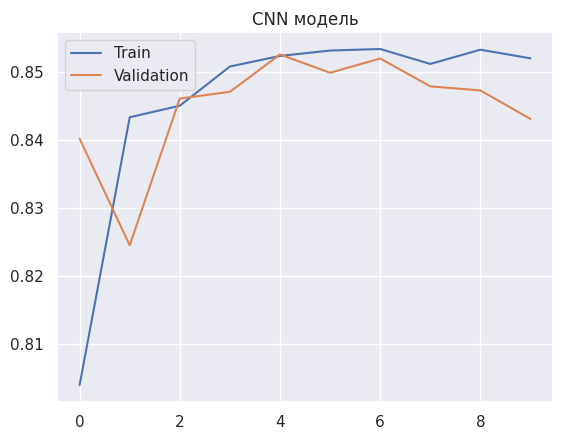

In [24]:
plt.plot(list(cnn_train_results[0].keys()), list(cnn_train_results[0].values()), label='Train')
plt.plot(list(cnn_train_results[1].keys()), list(cnn_train_results[1].values()), label='Validation')
plt.legend()
plt.title('CNN модель')

Лучший результат на валидации:

In [31]:
max(cnn_train_results[1].values())

0.8526

### MLP модель

Архитектура (в качестве эмбеддинга отзыва возмем среднее всех эмбеддингов слов):

In [26]:
class MLPModel(nn.Module):
    def __init__(self, embedding_vectors, hidden_size=100, dropout_prob=0.5):
        super(MLPModel, self).__init__()
        
        embedding_size = len(embedding_vectors[0])

        embedding_tensor = torch.vstack([torch.FloatTensor(embedding_vectors), torch.zeros((2, embedding_size))])
        
        self.embeddings = nn.Embedding.from_pretrained(embedding_tensor)
#         self.embeddings = nn.Embedding(len(embedding_vectors) + 2, embedding_size)
        
        self.fc_1 = nn.Linear(embedding_size, hidden_size)
        
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        self.fc_2 = nn.Linear(hidden_size, 2)
        
        self.dropout_1 = nn.Dropout(dropout_prob)
#         self.dropout_2 = nn.Dropout(dropout_prob)


    def forward(self, batch):       
        with torch.no_grad():
            embeddings_raw = self.embeddings(batch).transpose(1, 2)
            embeddings = embeddings_raw.mean(dim=-1)
    
        hidden_state_1 = self.dropout_1(nn.functional.relu(self.batch_norm(self.fc_1(embeddings))))
        
#         print(hidden_state_1.requires_grad)
        hidden_state_2 = self.fc_2(hidden_state_1)

        return nn.functional.softmax(hidden_state_2, dim=-1)         
        
        

In [27]:
mlp_model = MLPModel(w2v_model.wv.vectors, hidden_size=50).to(device)

optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss()
mlp_train_results = train(mlp_model, criterion, optimizer, 10, train_dataloader, test_dataloader)


| Epoch 0 | batch 0 | loss 0.0007090119123458862
| Epoch 0 | batch 50 | loss 0.001205284072802617

| Epoch 0 | training accuracy 0.740775 | mean loss 0.0011558290190166896
| Epoch 0 | validation accuracy 0.759

| Epoch 1 | batch 0 | loss 0.0005169191360473633
| Epoch 1 | batch 50 | loss 0.0009908955819331682

| Epoch 1 | training accuracy 0.828025 | mean loss 0.0009859861893418394
| Epoch 1 | validation accuracy 0.8286

| Epoch 2 | batch 0 | loss 0.00048348382115364074
| Epoch 2 | batch 50 | loss 0.0009435675614155256

| Epoch 2 | training accuracy 0.840625 | mean loss 0.0009434393121872419
| Epoch 2 | validation accuracy 0.8354

| Epoch 3 | batch 0 | loss 0.0004726683497428894
| Epoch 3 | batch 50 | loss 0.000916588870378641

| Epoch 3 | training accuracy 0.847075 | mean loss 0.0009235382705558965
| Epoch 3 | validation accuracy 0.8457

| Epoch 4 | batch 0 | loss 0.0004537814557552338
| Epoch 4 | batch 50 | loss 0.0009091042108260669

| Epoch 4 | training accuracy 0.849675 | mean loss

Text(0.5, 1.0, 'MLP модель')

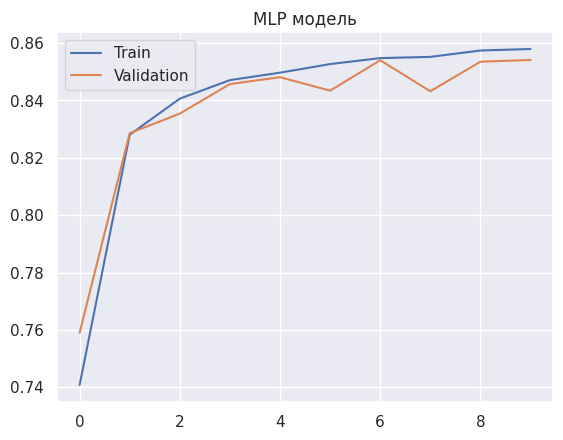

In [28]:
plt.plot(list(mlp_train_results[0].keys()), list(mlp_train_results[0].values()), label='Train')
plt.plot(list(mlp_train_results[1].keys()), list(mlp_train_results[1].values()), label='Validation')
plt.legend()
plt.title('MLP модель')

Лучший результат на валидации:

In [32]:
max(mlp_train_results[1].values())

0.8541

## Выводы

 - Неожиданно лучше всех себя показала самая базовая модель логистической регрессии
 - Из нейросетевых подходов побеждает базовая модель MLP (которая не учитывает контекст)

Возможные объяснения:
1. Подобраны не совсем оптимальные гиперпараметры для сложных моделей
2. Большинство отзывов насколько полярны, что даже средний эмбеддинг хорошо отделим
3. Построение эмбеддинга текста усреднением эмбеддингов слов - простой и не самый оптимальный способ, который съедает качество (например, не учитывает порядок слов)
4. Архитектура CNN в нашей реализации плохо себя показывает

Возможные варианты улучшения качества: 
1. Другие, более сложные архитектуры
2. Подбор гиперпараметров
3. Дополнительная преобработка датасета
4. Более качественные способы построения эмбеддингов текста